<DIV ALIGN=CENTER>

# Introduction to Network Analysis: Social Media
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython notebook, we build on the previous lessons in social media and network graph analysis to perform network graph analysis of twitter data. First, we will build a co-occurrence graph to indicate words (specifically hashtags) that are commonly used. Second, we will build a social graph and indicate directional associations (and possible natural groupings).

Since we will be performing twitter API calls, the twitter rate limitation will be an issue. This notebook has been designed to minimize API calls; however, you might still face problems, especially if you rerun the notebook or sections of code repeatedly. First, we perform our standard imports and indicate that plots should be made inline.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

-----

## Build co-occurrence graph

A co-occurrence graph connects words that occur together in a document, and are a special case of a [co-occurrence network][wcn]. In the example in this notebook, we will construct a co-occurrence graph of hashtags that occur together. As a string condition, we will search for tweets that contain the hashtag `#datascience`, and identify other hashtags that occur commonly with this same hashtag.

First, we must authorize our twitter application. In this case, we reuse the credentials you obtained in Week8 (if you lost those credentials, you should be able to return to the [twitter application][taw] website and obtain them as outlined in the [Week8 twitter notebook][tnb]. We also explicitly create a connection to twitter that indicates the notebook should wait out the twitter rate limitation (in case we exceed the allowed rate limits).

-----
[wcn]: https://en.wikipedia.org/wiki/Co-occurrence_networks
[taw]: https://apps.twitter.com
[tnb]: ../../Week8/notebooks/intro2smt.ipynb

In [2]:
# Inspired by Fernando Perez's demo code:
# https://gist.github.com/fperez/5681541
import tweepy as tw

# Order: Access Token, Access Token Secret, 
# Consumer Key, Consumer SecretAccess
# You can change this to a different file location as appropriate
cred_file = '../notebooks/twitter.cred'

tokens = []

with open(cred_file, 'r') as fin:
    for line in fin:
        if line[0] != '#': # Not a comment line
            tokens.append(line.rstrip('\n'))

auth = tw.OAuthHandler(tokens[2], tokens[3])
auth.set_access_token(tokens[0], tokens[1])

api = tw.API(auth, 
             wait_on_rate_limit=True, 
             wait_on_rate_limit_notify=True)

user = api.me()

print("Twitter Screen Name: ", user.screen_name)
print("Twitter Follower Count: ", user.followers_count)

Twitter Screen Name:  ProfBrunner
Twitter Follower Count:  140


-----

Now that our application has a connection to the Twitter API, we can perform our query. In this case, by default, we will request 2500 tweets that have the hashtag `#datascience`. From the results of this query, we build a list of tweet text that we parse to build up co-occurrence pairs. In the following two code cells, we display the total number of tweets, as well as the tweet with the maximum number of hashtags.

-----

In [3]:
# Number of tweets to get
# Note we will wait until we get them all, so keep small
num_tweets = 2500

# Search term: for us this is hashtag of interest
s_term = '#datascience'

# List we use throughout the first section of the the notebook
tweets = []

# Get the tweets
results = tw.Cursor(api.search, q=s_term).items(num_tweets)

# Build list from twitter search results
for result in results:
    tweets.append(result.text)

In [4]:
print('Total number of tweets = {0}'.format(len(tweets)))

Total number of tweets = 2500


In [5]:
# Print tweet with most hashtags

# Create list of hashtag counts
cnts = [tweet.count('#') for tweet in tweets]

# Find index of maximum entry
max_cnt = max(cnts)
max_idx = cnts.index(max_cnt)

print('Max hashtags in tweet (count = {0})'.format(cnts[max_idx]))
print(60*'-')
print(tweets[max_idx])

Max hashtags in tweet (count = 12)
------------------------------------------------------------
RT @e2d3org: #E2D3 is an #Excel add-in for #dataviz. #datajournalizm #OSS #GitHub #javascript #HTML5 #statistics #edtech #data #datascience…


-----

Given the list of tweets, we can now turn to building the co-occurrence graph. First, we tokenize each tweet, by searching for tokens that start with the `#` character. We strip off any trailing punctuation and turn all characters to lowercase. Next, we sort the list of tags, and add the list of tags to a set, which maintains an unordered collection of unique elements. Finally, we use the `combinations` method in `itertools` library to create all possible pairs of hashtags used in any tweet by using a `Counter` to accumulate the frequency with which hashtag pairs are found in all tweets. 

Thus, at the end of this code block, we have a set that contains all unique hashtags in any tweet, and a counter that has an occurrence count for every pair of hashtags over all tweets. We use these data collections in the following code cell to  display the total number of hashtags found and the tweet that contains the most hashtags.

-----

In [6]:
# We use several techniques below, referenced in the following URLs
#
# https://docs.python.org/dev/library/collections.html#collections.Counter
# https://docs.python.org/2/library/itertools.html#itertools.combinations
# https://docs.python.org/3/library/string.html#string.punctuation

from collections import Counter
from itertools import combinations
import string

tkns = set()
cnt = Counter()

# Iterate over all tweets
for tweet in tweets:
    
    # First, we use a list comprehension that extract hashtags
    # We strip off leading '#', then remove trailing punctuation.
    # And turn all characters to lowercase.
    # Note this is not Unicode clean.
    # Finally, we sort the list of tags (which will ensure the
    # Counter works correctly)
    
    tags = sorted([tag.lstrip("#").rstrip(string.punctuation).lower() 
            for tag in tweet.split() if tag.startswith("#")])
    
    # We now build our set of tokens
    
    for tag in tags:
        tkns.add(tag)
            
    # Next we use combinations from the itertools library 
    # to make a list of tag pairs. 
    # We then increment the counter for each paried tag

    for paired_tags in combinations(tags, 2):
        cnt[paired_tags] += 1

# How many hashtags did we extract?
print('Total number of unique hashtags = {0}'.format(len(tkns)))

# Extract the top pair, list of tuples (pair, count)
mc = cnt.most_common(1)[0]
print('Total number of paired tags = {0}'.format(len(cnt)))
print('Most common pair = {0}, occurs {1} times.'.format(mc[0], mc[1]))

Total number of unique hashtags = 639
Total number of paired tags = 3066
Most common pair = ('bigdata', 'datascience'), occurs 1235 times.


In [7]:
# Now we go through pair counter for top pairs to build a network.

top_tkns = set()
num_top_pairs = 25

# Get most common pairs
top_pairs = cnt.most_common(num_top_pairs)

# Get most frequenly used tokens
for pair, count in top_pairs:
    top_tkns.add(pair[0])
    top_tkns.add(pair[1])

print('Total number of unique hashtags = {0}\n'.format(len(top_tkns)))
print('Hashtags to graph:')
print(40*'-')
print(top_tkns)

Total number of unique hashtags = 10

Hashtags to graph:
----------------------------------------
{'analytics', 'ai', 'datascience', 'bigdata', 'deeplearning', 'ml', 'machinelearning', 'abdsc', 'iot', 'python'}


-----

Now that we have built the co-occurrence data collection, we can use the networkx library to build and display the co-occurrence graph. In this case, we have an undirected graph. We first set up our graph, which will be drawn by using the individual methods for drawing nodes, edges, and labels for maximum control of the layout. Next, we create the undirected graph, add the nodes from the `top_tkns` set, and add the edges (with appropriate weight values defined by the count of the occurrence of the pair). 

Next we layout the appearance of our graph, which in the first plot uses the `circular_layout`. We draw the nodes, before building up special lists to allow us to control the appearance of the edges. We do this so that we can set the width of each edge in the plot to be proportional to the weight (or number of times the pair of hashtags appeared). We normalize the widths so that the minimum count has width unity. Finally, we draw the edges and label the nodes. As the resulting plot demonstrates, certain pairs of hashtags occur quite commonly together, such as `datascience` and `bigdata`. 

-----

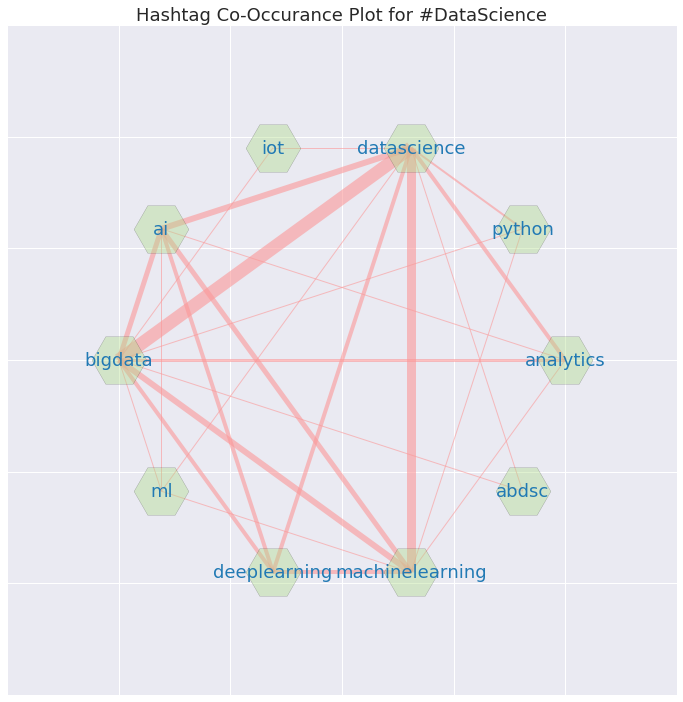

In [8]:
# First setup the current figure. 
# No Axes, no Axes labels, white background

fig, axes = plt.subplots(figsize=(12, 12))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

sns.despine(top = True, bottom = True, 
            left = True, right = True)

axes.set_xticklabels([])
axes.set_yticklabels([])

# Build graph

import networkx as nx

g = nx.Graph()

g.add_nodes_from(list(top_tkns))

for pair, count in top_pairs:
    g.add_edge(pair[0], pair[1], weight=count)

# Now draw graph, use circular layout

pos = nx.circular_layout(g)

nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_size = 3000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)

# Build up list of edges and weights for controlled plotting
edges = []
weights = []

for n1, n2, dct in g.edges(data=True):
    edges.append((n1, n2))
    weights.append(dct['weight'])

# Make normalized weights (scale to minimum weight)
min_weight = min(weights)
norm_weights = [int(weight/min_weight) for weight in weights]

# Draw weighted edges, we pass in the edgelist so we can 
# also pass in the edge weights individually
nx.draw_networkx_edges(g, pos, edgelist=edges, 
                       width = norm_weights, 
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)

# Now label nodes, since we don't provide lables, it uses the 
# default labels (which is what we want)
nx.draw_networkx_labels(g, pos, font_size = 18,
                        font_color = clrs[1],
                        alpha = 1.0)

plt.title('Hashtag Co-Occurance Plot for #DataScience')
plt.show()

-----

### Student Activity

In the preceding cells, we introduced the creation of a co-occurence graph. Now that you have run the Notebook, go back and make the following changes to see how the results change.

1. Change the plot to use a `spring_layout`. Do you see any natural clustering? What does this tell you about the most commonly used hashtags?
2. Replace the initial hashtag `datascience` with a hashtag of your own choice. Repeat the previous code cells, does your new plot make sense? 
3. Try using more tweets (i.e,, 2500 in the existing code) and most common tokens (i.e. 25 in the existing code). How do the results and plot change?

-----

## Social Graph

As our second example, we will construct a social graph. In this case, we will start with the instructor (`ProfBrunner`), and his friends, which allows us to build a directed graph. Next, we will obtain the friends of his friends in order to identify bi-directional associations (i.e., user a follows user b and vice versa). If each user follows the other, we have a bi-directional edge; otherwise, we have a uni-directional edge.

To get started, we reuse our existing API to build up a list of the initial user's friends. In order to minimize calls to the twitter API, we employ several tricks. First, we limit the number of friends at the start (to stay below the fifteen calls within an hour for friend searches). Second, we maintain our mapping between twitter id and screen name, which we construct when we grab the twitter id's for each friend of the initial user. 

-----

In [ ]:
#user = api.me()

# Explicitly get instructor, can change.
user = api.get_user('ProfBrunner')

# We accumulate a list of ids for our friends
my_friends = []

# We map id to screen names to minimize twitter calls
id2name = {}
id2name[user.id] = user.screen_name

# Note: I remove extra users to reduce chance of rate limits later.
# The '*Fact' accounts don't follow peopel (in general)

print('\n{0} follows:\n--------------'.format(user.screen_name))
for friend in user.friends():
    if 'Fact' not in friend.screen_name:
        print(friend.screen_name)
        my_friends.append(friend.id)
        id2name[friend.id] = friend.screen_name


ProfBrunner follows:
--------------
adriancolyer
hmason
AlbCarrascal
Dilbert_Daily
xkcdComic
ML_Hipster
PHDcomics
benorlin
redpenblackpen
Cmrn_DP
AleyBrunner
LauraFrerichs
googleresearch
jakevdp
powersoffour
NateSilver538
flowingdata


-----

Given the initial data, we now use the twitter API to grab the ids for all friends of the friends of the initial user. Note that this may take some time if rate limits have been exceeded at any point.

-----

In [ ]:
# To minimize twitter API calls, we grab the friend ids for all of the
# current user's friends. This needs to be less than 15 or we can hit
# rate limits. Also, don't rerun frequently, or you may hit rate limits.

ids2ids = {}
ids2ids[user.id] = my_friends

# We loop over our friends. We could limit this to first n (n < 15) to
# minimize any chance of hitting a rate limits

for friend in my_friends:
    
    print('Finding friends for {0}'.format(id2name[friend]))
    
    ids2ids[friend] = api.friends_ids(friend)
    
    print('Found {0} friends.'.format(len(ids2ids[friend])))

Finding friends for adriancolyer
Found 293 friends.
Finding friends for hmason
Found 1403 friends.
Finding friends for AlbCarrascal
Found 442 friends.
Finding friends for Dilbert_Daily
Found 25 friends.
Finding friends for xkcdComic
Found 1 friends.
Finding friends for ML_Hipster
Found 0 friends.
Finding friends for PHDcomics
Found 80 friends.
Finding friends for benorlin
Found 169 friends.
Finding friends for redpenblackpen
Found 39 friends.
Finding friends for Cmrn_DP
Found 795 friends.
Finding friends for AleyBrunner
Found 343 friends.
Finding friends for LauraFrerichs
Found 476 friends.
Finding friends for googleresearch
Found 19 friends.
Finding friends for jakevdp
Found 324 friends.
Finding friends for powersoffour
Found 1052 friends.
Finding friends for NateSilver538
Rate limit reached. Sleeping for: 896


-----

Now that we have a mapping between friend id and the ids of the friends of the friend, we can build a directed social graph. This social graph will only contain nodes for the initial user and the direct friends of the initial user. This will limit both twitter calls, and the size of the graph. To make this graph, we first create the directed graph, and add a node for the initial user. Next, we step through the ids of the user's friends; and inside this loop, we step through the friend of friend ids for the current friend to identify any associations back to the original list of friends. As we find matches, we add an edge to the graph as appropriate. 

Note that when we add a link between _user a_ and _user b_, any nodes not yet in existence will be created. Also, when we add a second link between _user b_ and _user a_, the edge between these two nodes becomes bi-directional.

-----

In [ ]:
# Now we use the cached friends ids and the 
# dictionary mapping between ids and names
# to build edges in the directed graph.

# Make a copy of the ids, and add the current user id
# Doing this means we can find bi-directional edges
ids = my_friends.copy()
ids.append(user.id)

# Create directed graph and add first node
dg = nx.DiGraph()
dg.add_node(user.screen_name)

# Find edges in social graph and add to the graph.
# We find friends of friends (fof) in the retreived ids
for id in ids:
    for fof in ids2ids[id]:
        if fof in ids:
            dg.add_edge(id2name[id], id2name[fof])

-----

With the directed graph created, we can now draw the graph. As we did in the first demonstration in this notebook, we first set up the plot, before drawing the individual components. This first visualization follows the previous graph visualization in drawing nodes, edges and labels separately.

-----

In [ ]:
# First setup the current figure. 
# No axes, no Axes labels, white background

fig, axes = plt.subplots(figsize=(12, 12))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

sns.despine(top = True, bottom = True, 
            left = True, right = True)

axes.set_xticklabels([])
axes.set_yticklabels([])

# Now draw graph, use circular layout

#pos = nx.spring_layout(dg)
pos = nx.circular_layout(dg)

# Draw the nodes
nx.draw_networkx_nodes(dg, pos, with_labels=True,
                       node_size = 2000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)

# Draw the edges, all use the same widths.
nx.draw_networkx_edges(dg, pos,
                       width = 1,
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)

# Add the labels
nx.draw_networkx_labels(dg, pos, font_size = 14,
                        font_color = clrs[1],
                        alpha = 1.0)

plt.title('Social connections for {0}'.format(user.screen_name))
plt.show()

-----

While the circular layout allows the nodes to be easily visualized, it complicates the visualization of relationships between the nodes. In this case, we can change the graph plot layout, to better reflect natural groupings. The following code cell shows this by using the `spring_layout`, which in this case highlight natural groupings between the nodes.

----

In [ ]:
# First setup the current figure. 
# No axes, no Axes labels, white background

fig, axes = plt.subplots(figsize=(12, 12))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

sns.despine(top = True, bottom = True, 
            left = True, right = True)

axes.set_xticklabels([])
axes.set_yticklabels([])

# Now draw graph, use spring layout

pos = nx.spring_layout(dg)

# Draw the nodes
nx.draw_networkx_nodes(dg, pos, with_labels=True,
                       node_size = 2000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)

# Draw the edges, with the same width
nx.draw_networkx_edges(dg, pos,
                       width = 1,
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)

# Label the nodes
nx.draw_networkx_labels(dg, pos, font_size = 14,
                        font_color = clrs[1],
                        alpha = 1.0)

plt.title('Social connections for {0}'.format(user.screen_name))
plt.show()

-----

### Student Activity

In the preceding cells, we introduced the concept of a social graph and constructed one by using the twitter data for the course instructor. Now that you have run the Notebook, go back and make the following changes to see how the results change.

1. Change the initial user to someone else, perhaps yourself or to a famous celebrity. You will likely want to limit the number of friends followed to reduce the impact of the twitter rate limit (or let the code run overnight. What does the social graph tell you?
2. Try changing the weight of an edge to reflect the number of retweets between any two users.
3. Try analyzing the social graph to find the `radius`, `center`,  `diameter`, `eccentricity`, and `density`.

-----